In [24]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from einops import rearrange
import requests
import io
import json
from tqdm import tqdm

In [4]:
import mediapy as media

In [5]:
!ls -t baselines

session_12ec2684	  requirements.txt
red_gym_env.py		  session_4ae92fc6
__pycache__		  session_9c9635d2
run_baseline_parallel.py  session_2840349a
session_a29498a2	  session_08a69445
session_45a0b294	  session_ee58c5e4
session_6228d517	  session_074fa27e
session_90171d9a	  session_c8832715_moonrun.zip
session_21d79997	  session_1256e7e0
session_11109d82	  session_8aa8bf73
session_f88aa4c9	  session_41639a57
session_ff005d39	  session_f3005434
session_a5faa12e	  session_35f5fa31
session_e62631a0	  session_295a0947
session_ebdfe818	  session_3284058c
delete_empty_imgs.txt	  session_a816e3d6
session_d2036395	  session_2fe0ddf4_fixed_lr
session_04a6f185	  session_bfdca25a
session_6734c3c4	  run_baseline.py
session_e41c9eff	  grinds_to_level_11_extra_time_14
session_cd675584	  best_12-7
session_2ebe37d8	  session_b30478f4_mt_moon


In [6]:
run_dir = Path('baselines/session_e41c9eff') # Path('baselines/session_ebdfe818')

In [7]:
dfs = []
for run in tqdm(run_dir.glob('*.gz')):
    dfs.append(pd.read_csv(run, compression='gzip'))

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,2,3,4,5,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
4it [00:27,  6.99s/it]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
dfs[0].keys()

In [ ]:
all_levels = np.stack([tdf[['levels']].to_numpy() for tdf in filter_dfs(dfs)])

In [8]:
sdf = pd.read_csv(next(run_dir.glob('*.gz')), compression='gzip')

In [12]:
test_levels = np.stack([arr for arr in sdf['levels'].to_numpy()])

(5702327,)

In [34]:
levels = np.stack(filter_dfs([sdf])[0]['levels'].map(json.loads).map(np.array))

In [ ]:
for run in tqdm(run_dir.glob('*.gz')):
    levels = np.stack(filter_dfs([pd.read_csv(run, compression='gzip')])[0]['levels'].map(json.loads).map(np.array))
    sums = levels.sum(1)-6
    for i in range(len(sums)-1):
        cur = sums[i]
        nx = sums[i+1]
        if nx < cur and nx != 0:
            print(i)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,2,3,4,5,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
13it [07:02, 32.41s/it]

In [27]:
#dfs[0][dfs[0]['x'] == 'x']

In [31]:
def filter_dfs(dfs):
    return [
        tdf[tdf['map'] != 'map']
        for tdf in dfs
    ]

In [10]:
def make_all_coords_arrays(filtered_dfs):
    return np.stack([tdf[['x', 'y', 'map']].to_numpy().astype(np.uint8) for tdf in filtered_dfs]).transpose(1,0,2)

In [11]:
base_coords = make_all_coords_arrays(filter_dfs(dfs)) #level_z[['x', 'y', 'map']].to_numpy().astype(np.uint8)
base_coords.shape

(5701980, 44, 3)

In [12]:
del dfs

In [13]:
#level_z = sdf[(sdf['map'] == '0') | (sdf['map'] == '12') | (sdf['map'] == '1')] # sdf[(sdf['map'] == '1')] #

In [14]:
sprites = {
    'characters': 'https://www.spriters-resource.com/resources/sheets/8/8728.png',
    0: 'https://www.spriters-resource.com/resources/sheets/52/55181.png'
}

In [15]:
main_map = np.array(Image.open('RoughMap.png'))

In [16]:
def load_tex(name):
    resp = requests.get(sprites[name])
    return np.array(Image.open(io.BytesIO(resp.content)))

In [17]:
def get_sprite_by_coords(img, x, y):
    sy = 34+17*y
    sx = 9 +17*x
    alpha_val = np.array([255, 127,  39, 255], dtype=np.uint8)
    sprite = img[sy:sy+16, sx:sx+16]
    return np.where((sprite == alpha_val).all(axis=2).reshape(16,16,1), np.array([[[0,0,0,0]]]), sprite).astype(np.uint8)


In [18]:
chars_img = load_tex('characters')

In [19]:
alpha_val = get_sprite_by_coords(chars_img, 1, 0)[0,0]
alpha_val

array([0, 0, 0, 0], dtype=uint8)

In [20]:
walks = [get_sprite_by_coords(chars_img, x, 0) for x in [1, 4, 6, 8]]

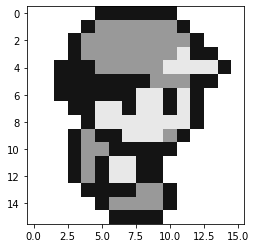

In [21]:
plt.imshow(walks[3])

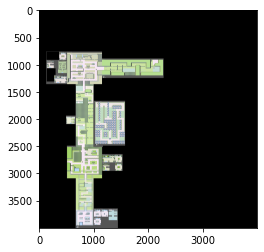

In [22]:
plt.imshow(main_map)

In [23]:
def add_sprite(overlay_map, sprite, x, y, map_idx, opacity=1.0, add=True):
    global_offset = np.array([1062-16*24, 338]) #np.array([790, -29])
    map_offsets = {
        # https://bulbapedia.bulbagarden.net/wiki/List_of_locations_by_index_number_(Generation_I)
        0: np.array([0,0]), # pallet town
        1: np.array([-10, 72]), # viridian
        2: np.array([-10, 180]), # pewter
        12: np.array([0, 36]), # route 1
        13: np.array([0, 144]), # route 2
        51: np.array([22, 123]) # viridian forest
    }
    if map_idx in map_offsets.keys():
        offset = map_offsets[map_idx]
    else:
        offset = np.array([0,0])
        x, y = 0, 0
    coord = global_offset + 16*(offset + np.array([x,y]))
    coord[1] = overlay_map.shape[0] - coord[1]
    base = (overlay_map[coord[1]:coord[1]+16, coord[0]:coord[0]+16, :]).astype(np.float32)
    new = opacity*sprite.astype(np.float32)
    if add:
        intermediate = base + new
    else:
        intermediate = new
    overlay_map[coord[1]:coord[1]+16, coord[0]:coord[0]+16, :] = intermediate.clip(0, 255).astype(np.uint8)

In [24]:
def blend_overlay(background, over):
    al = over[...,3].reshape(over.shape[0], over.shape[1], 1)
    ba = (255-al)/255
    oa = al/255
    return (background[..., :3]*ba + over[..., :3]*oa).astype(np.uint8)

In [25]:
#sdf.head(50)
base_coords[0, :20]

array([[ 4,  3, 40],
       [ 5,  3, 40],
       [ 5,  3, 40],
       [ 5,  3, 40],
       [ 5,  4, 40],
       [ 4,  3, 40],
       [ 4,  3, 40],
       [ 5,  3, 40],
       [ 5,  3, 40],
       [ 4,  3, 40],
       [ 5,  3, 40],
       [ 5,  4, 40],
       [ 5,  4, 40],
       [ 5,  3, 40],
       [ 5,  3, 40],
       [ 5,  3, 40],
       [ 5,  3, 40],
       [ 5,  3, 40],
       [ 4,  3, 40],
       [ 5,  3, 40]], dtype=uint8)

In [26]:
def render_coords(coords, over):
    for x,y,mp in coords:
        add_sprite(over, walks[0], int(x), -int(y), mp, add=False)

In [27]:
start = main_map.copy()
overlay = np.zeros_like(start, dtype=np.uint8)

In [37]:
#add_sprite(overlay, walks[0], -12, -11, 0)
render_coords(base_coords[:39500, 0], overlay)

In [29]:
def split(img):
    return rearrange(img, '(s y) x c -> y (s x) c', s=2)

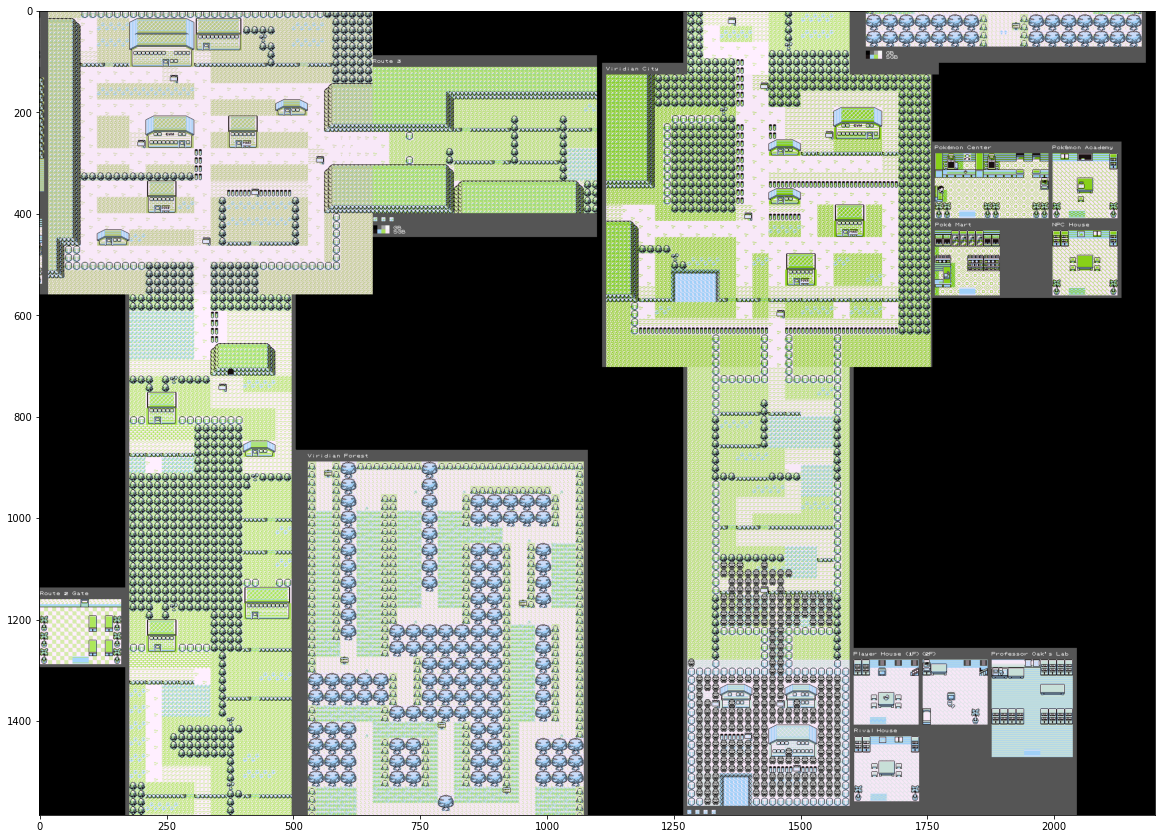

In [38]:
plt.figure(figsize = (20,20))
plt.imshow(split(blend_overlay(start, overlay)[800:3970, 500:1600]))

In [908]:
overlay.shape

(4000, 4000, 4)

In [32]:
def render_video(all_coords, bg):
    over = np.zeros_like(bg, dtype=np.uint8)
    with media.VideoWriter('test_out_800kplus.mp4', split(bg[800:3970, 500:1600]).shape[:2], fps=60) as wr:
        for idx, step in tqdm(enumerate(all_coords)):
            if idx % 2 == 0:
                over[over > 0] -= 1
            for x,y,mp in step:
                add_sprite(over, walks[0], int(x), -int(y), mp)
            if idx % 10 == 0:
                wr.add_image(split(blend_overlay(bg[800:3970, 500:1600], over[800:3970, 500:1600])))

In [ ]:
render_video(base_coords[1700000:2500000], start)

29419it [17:12, 32.41it/s]

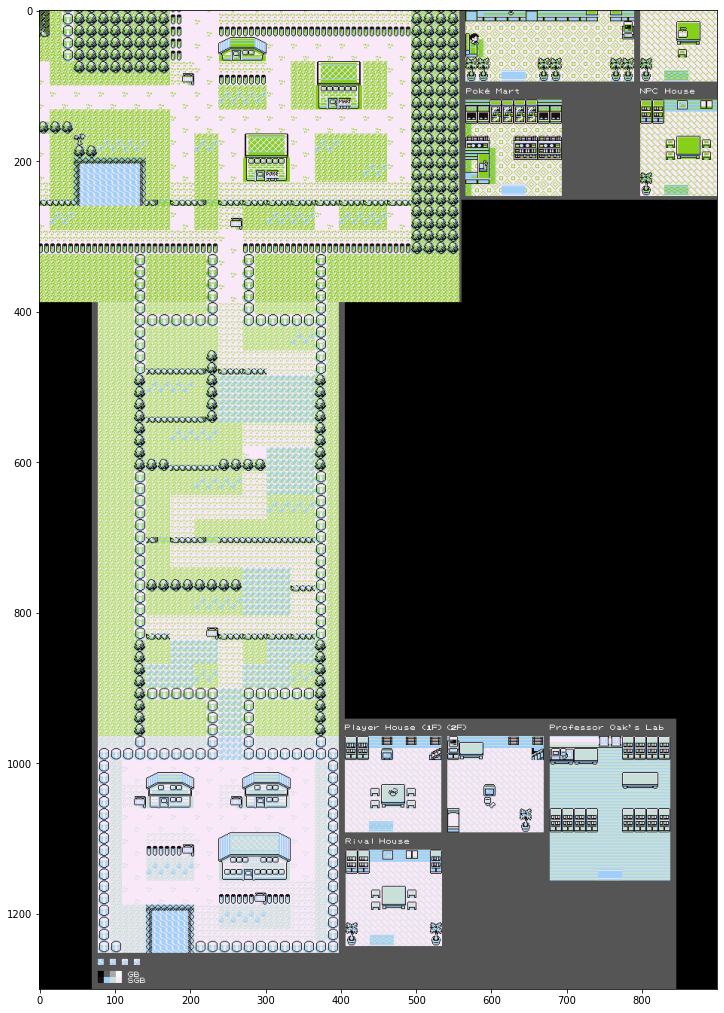

In [909]:
plt.figure(figsize = (18,18))
plt.imshow(start[2700:, 600:1500])

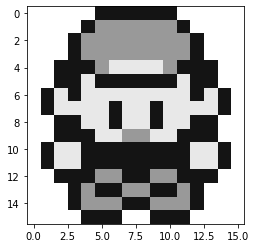

In [651]:
plt.imshow(walks[0])